In [1]:
%matplotlib notebook
#%matplotlib inline
# standard imports 
from __future__ import division 
from __future__ import print_function 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from glob import glob 

In [2]:
# imports for playing with fits files 
from sunpy.net import Fido, attrs
from datetime import datetime, timedelta
import astropy.units as u 
import sunpy.map as smap 
from astropy.coordinates import SkyCoord 
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel
from datetime import datetime, timedelta
import matplotlib.dates as mdates 

In [3]:
from AIA_tools import * 

In [4]:
fits_files = {'171': glob("/data/khnum/REU2018/jwaczak/fitsFiles/171/*.fits"), 
              '193': glob("/data/khnum/REU2018/jwaczak/fitsFiles/193/*.fits"), 
              '211': glob("/data/khnum/REU2018/jwaczak/fitsFiles/211/*.fits"), 
              '304': glob("/data/khnum/REU2018/jwaczak/fitsFiles/304/*.fits"), 
              '335': glob("/data/khnum/REU2018/jwaczak/fitsFiles/335/*.fits")}

num_wavelengths = 5 
assert(len(fits_files['171'])==len(fits_files['193']))
assert(len(fits_files['193'])==len(fits_files['211']))
assert(len(fits_files['211'])==len(fits_files['304']))
assert(len(fits_files['304'])==len(fits_files['335']))
assert(len(fits_files['335'])==len(fits_files['171'])) 



** Create our maps, submaps, and tiny boxes for analysis ** 

In [5]:
data_maps = {'171':[], '193':[], '211':[], '304':[], '335':[]}
sub_maps = {'171':[], '193':[], '211':[], '304':[], '335':[]}
tiny_box = {'171':[], '193':[], '211':[], '304':[], '335':[]}

# submap coordinates in arcseconds 
sm_bl_x =700 
sm_bl_y = -700 
sm_tr_x = 1200 
sm_tr_y = -200 

# tiny box coordinates in arcseconds
dr = 15 
tb_bl_x = 1145 
tb_bl_y = -410
tb_tr_x = 1145+dr 
tb_tr_y = -410+dr 


for key in data_maps: 
    data_maps[key].append(smap.Map(fits_files[key][50]))
    sub_maps[key].append(analysis.makeSubmap(data_maps[key][0], sm_bl_x, sm_bl_y, sm_tr_x, sm_tr_y))
    tiny_box[key].append(analysis.makeSubmap(data_maps[key][0], tb_bl_x, tb_bl_y, tb_tr_x, tb_tr_y)) 
        

/usr/local/anaconda2/lib/python2.7/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


** Let's see if we can replicate figure 2 from Ma et al. Paper before animating full time dependence ** 

<IPython.core.display.Javascript object>


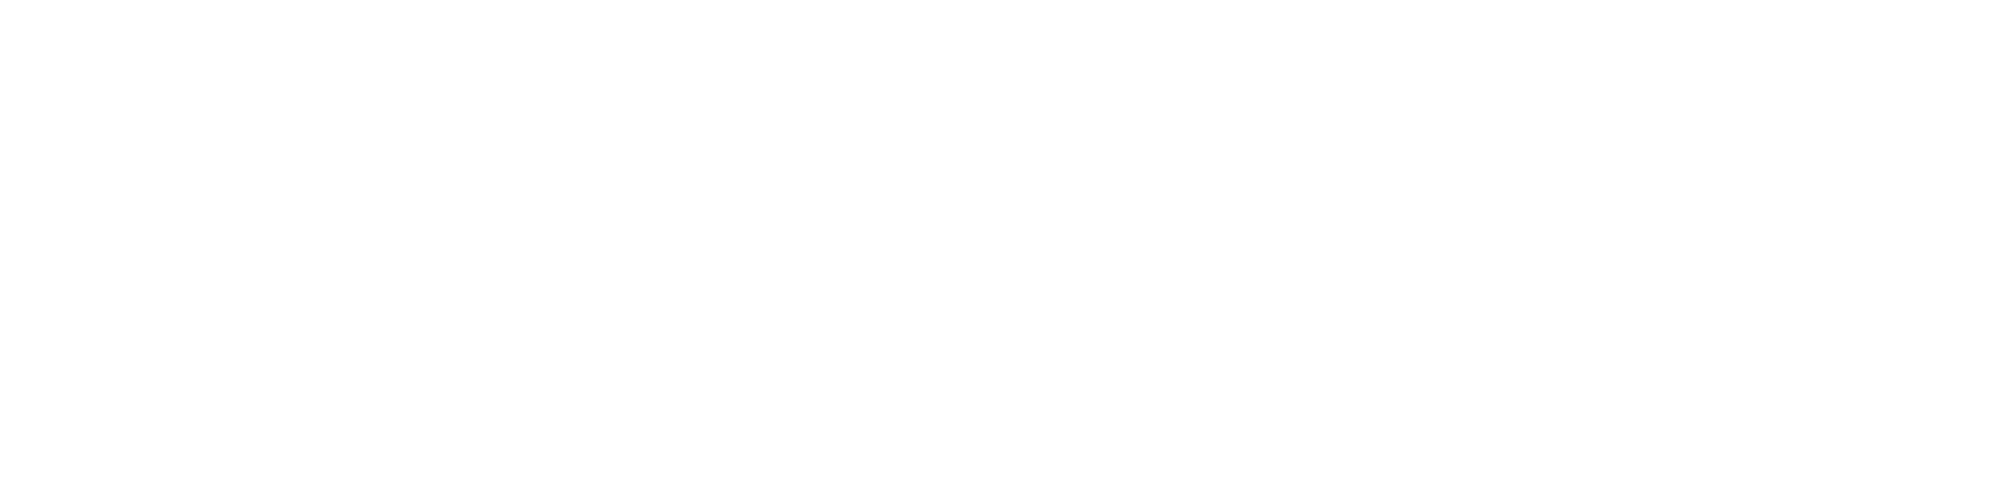

In [6]:
import matplotlib
with matplotlib.pyplot.style.context(('dark_background')):
    fig = plt.figure(figsize=(20, 5)) 
    i = 1 
    for key in sub_maps: 
        ax_i = plt.subplot(1, 5, i, projection = sub_maps[key][0])
        sub_maps[key][0].plot() 
        bl = SkyCoord(tb_bl_x*u.arcsec, tb_bl_y*u.arcsec,
                           frame=sub_maps[key][0].coordinate_frame) 
        sub_maps[key][0].draw_rectangle(bl, dr*u.arcsec, dr*u.arcsec)
        i+=1
    
    plt.tight_layout() 
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.4, hspace=None)
    plt.savefig('/data/khnum/REU2018/jwaczak/data/multChannelsWithBox.png', transparent=True)
    plt.show()
    

** Okay, I think this box looks good. ** 

In [7]:
intensities = {'171':[], '193':[], '211':[], '304':[], '335':[]}
times =  {'171':[], '193':[], '211':[], '304':[], '335':[]}

data_maps = {}
sub_maps = {}
tiny_box = {}

for i in range(len(fits_files['171'])): 
    print(i) 
    for key in intensities:
        data_maps[key] = smap.Map(fits_files[key][i])
        sub_maps[key] = analysis.makeSubmap(data_maps[key], sm_bl_x, sm_bl_y, sm_tr_x, sm_tr_y)
        tiny_box[key] = analysis.makeSubmap(data_maps[key], tb_bl_x, tb_bl_y, tb_tr_x, tb_tr_y)
        intensities[key].append(np.average(tiny_box[key].data)) 
        time = tiny_box[key].meta['date_obs'] 
        time = datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%f')
        times[key].append(time) 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


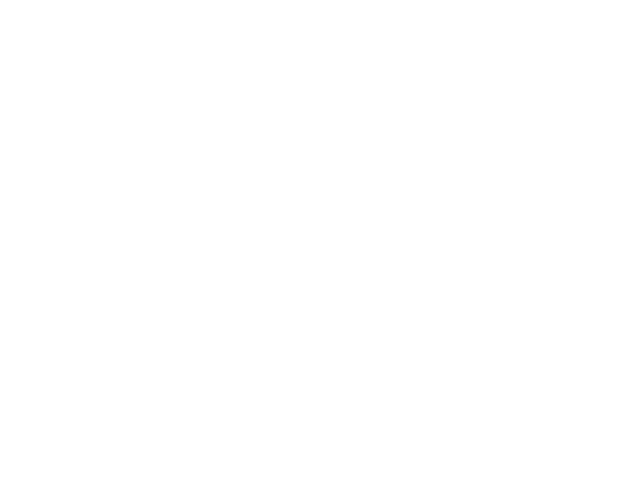

In [8]:
import matplotlib

with matplotlib.pyplot.style.context(("dark_background")):
    fig, ax = plt.subplots() 

    ax.plot(times['171'], intensities['171'], label='$171$ $\AA$') 
    ax.plot(times['193'], intensities['193'], label='$193$ $\AA$')
    ax.plot(times['211'], 5*np.asarray(intensities['211']), label='$211 \cdot 5$ $\AA$')
    ax.plot(times['304'], 50*np.asarray(intensities['304']), label='$304 \cdot 50$ $\AA$')
    ax.plot(times['335'], 125*np.asarray(intensities['335']), label='$335 \cdot 125$ $\AA$') 
    
    fig.autofmt_xdate()
    myFmt = mdates.DateFormatter('%H:%M:%S')    
    ax.xaxis.set_major_formatter(myFmt) 
    
    ax.axvline(x=times['171'][46])
    ax.text(times['171'][47],30,'Shock',rotation=90)
    ax.axvline(x=times['171'][59])
    ax.text(times['171'][60], 30, 'CME', rotation=90)
    

    ax.set_ylabel("Intensity [DN $s^{-1} pix^{-1}$]")
    ax.set_xlabel("Time [$\Delta t = 12$ s]")
    ax.set_title('CME and Shock Observation Data')
    ax.legend(frameon=False) 
    plt.savefig('/data/khnum/REU2018/jwaczak/data/observation_window.png', transparent=True)
    plt.show()


In [9]:
pathToObs = '/data/khnum/REU2018/jwaczak/data/observationData/'

with open(pathToObs+'orig_times.txt', 'w') as f: 
    for i in range(len(times['171'])): 
        f.write('171:\t{}\t191:\t{}\t211:\t{}\t304:\t{}\t335:\t{}\n'.format(times['171'][i], times['193'][i], times['211'][i], times['304'][i], times['335'][i]))   

with open(pathToObs+'orig_intensities.txt', 'w') as f: 
    for i in range(len(times['171'])): 
        f.write('171:\t{}\t191:\t{}\t211:\t{}\t304:\t{}\t335:\t{}\n'.format(intensities['171'][i], intensities['193'][i], intensities['211'][i], intensities['304'][i], intensities['335'][i]))   
    

** Now, let's average the data for the channels before the shock to get some good background data ** 

In [10]:
back_171 = np.asarray(intensities['171'][20:40]).mean() 
back_193 = np.asarray(intensities['193'][20:40]).mean() 
back_211 = np.asarray(intensities['211'][20:40]).mean() 
back_304 = np.asarray(intensities['304'][20:40]).mean() 
back_335 = np.asarray(intensities['335'][20:40]).mean() 

print(back_171, back_193, back_211, back_304, back_335) 

42.10212355077331 44.31490303242575 9.53621870492062 0.9958804485857156 0.32414652287683743


In [11]:
with open('/data/khnum/REU2018/jwaczak/data/background.txt', 'w') as f: 
    f.write('# 171, 193, 211, 304, 335\n')
    f.write('{}, {}, {}, {}, {}'.format(back_171, back_193, back_211, back_304, back_335))

In [12]:
x_i = (tb_bl_x + tb_tr_x)/2.0
y_i = (tb_bl_y + tb_tr_y)/2.0
print(x_i, y_i)

1152.5 -402.5


** Now, get length of radius in arcseconds from center of CME and from flare on limb ** 

In [13]:
x0_c = 973
y0_c = -476 

R_c = np.sqrt((x_i-x0_c)**2 + (y_i-y0_c)**2)

arcsec_per_pixel = data_maps['171'].meta['cdelt1']
arcsec_per_solarRadii = data_maps['171'].meta['rsun_obs']
km_per_solarRadii = data_maps['171'].meta['RSUN_REF']/1000.0 # [km]
solarRadii_per_pixel = arcsec_per_pixel / arcsec_per_solarRadii
#print(arcsec_per_pixel, arcsec_per_solarRadii, R_sun_meters, solarRadii_per_pixel)

r0_center = (R_c*(1/arcsec_per_solarRadii))*km_per_solarRadii
print(r0_center)

142893.7485647755


In [14]:
x0_l = 855
y0_l = -400 

R_l = np.sqrt((x_i-x0_l)**2+(y_i-y0_l)**2)

r0_limb = (R_l*(1/arcsec_per_solarRadii))*km_per_solarRadii

print(r0_limb)

219175.3494159305


In [15]:
with open('/data/khnum/REU2018/jwaczak/data/initialRadii.txt', 'w') as f: 
    f.write('# from center of CME, from Limb --- Distance to viewing window\n')
    f.write('{}, {}'.format(r0_center, r0_limb))

** Now let's interpolate the data to the 171A times and chop it according to the figure above ** 

In [16]:
# get the times
time_in_seconds = {'171':[], '193':[], '211':[], '304':[], '335':[]}
#data_maps = {'171':[], '193':[], '211':[], '304':[], '335':[]}

for key in times:
    # start the times at zero seconds and add that to the list 
    tot = 0.0
    time_in_seconds[key].append(tot)

    # get difference and add to tot
    for i in range(1, len(times[key])): 
        t_diffs =(times[key][i]-times[key][i-1]).total_seconds()
        tot += t_diffs
        print('\t', tot)
        time_in_seconds[key].append(tot) 

        
# use the 171 A times as that is how we defined the start of the cme 

# create interpolation objects 
interp_193 = interp1d(time_in_seconds['193'], intensities['193']) 
interp_211 = interp1d(time_in_seconds['211'], intensities['211'])
interp_304 = interp1d(time_in_seconds['304'], intensities['304']) 
interp_335 = interp1d(time_in_seconds['335'], intensities['335']) 


# interpolate the times to the 171 times  
time_vals =  np.asarray(time_in_seconds['171'][46:60])
intensities['171'] = intensities['171'][46:60]
intensities['193'] = interp_193(time_vals) 
intensities['211'] = interp_211(time_vals) 
intensities['304'] = interp_304(time_vals) 
intensities['335'] = interp_335(time_vals) 

Dt = np.around(np.abs(time_vals[1:]-time_vals[:-1]).mean()) # should give 12.0 
print(Dt)
time_vals = np.arange(0, len(time_vals)*Dt, Dt)



	 12.02
	 24.0
	 36.02
	 48.0
	 60.02
	 72.0
	 84.03
	 96.0
	 108.02
	 120.0
	 132.02
	 144.03
	 156.02
	 168.03
	 180.02
	 192.0
	 204.02
	 216.0
	 228.02
	 240.0
	 252.02
	 264.01
	 276.02
	 288.0
	 300.02
	 312.0
	 324.02
	 336.03
	 348.02
	 360.0
	 372.02
	 384.0
	 396.02
	 408.0
	 420.02
	 432.0
	 444.02
	 456.0
	 468.02
	 480.0
	 492.03
	 504.03
	 516.02
	 528.0
	 540.02
	 552.0
	 564.02
	 576.0
	 588.02
	 600.0
	 612.02
	 624.0
	 636.02
	 648.0
	 660.02
	 672.0
	 684.02
	 696.03
	 708.02
	 720.0
	 732.02
	 744.03
	 756.02
	 768.0
	 780.02
	 792.0
	 804.02
	 816.0
	 828.02
	 840.0
	 852.02
	 864.03
	 876.02
	 888.0
	 900.02
	 912.0
	 924.02
	 936.03
	 948.02
	 960.0
	 972.02
	 984.03
	 996.02
	 1008.01
	 1020.02
	 1032.02
	 1044.03
	 1056.0
	 1068.02
	 1080.0
	 1092.02
	 1104.03
	 1116.02
	 1128.02
	 1140.02
	 1152.0
	 1164.02
	 1176.03
	 1188.02
	 11.99
	 24.0
	 35.99
	 48.0
	 59.99
	 72.0
	 83.99
	 96.0
	 107.99
	 120.0
	 131.99
	 144.0
	 156.01
	 168.0
	 179.99
	 192.0
	 203.9

<IPython.core.display.Javascript object>


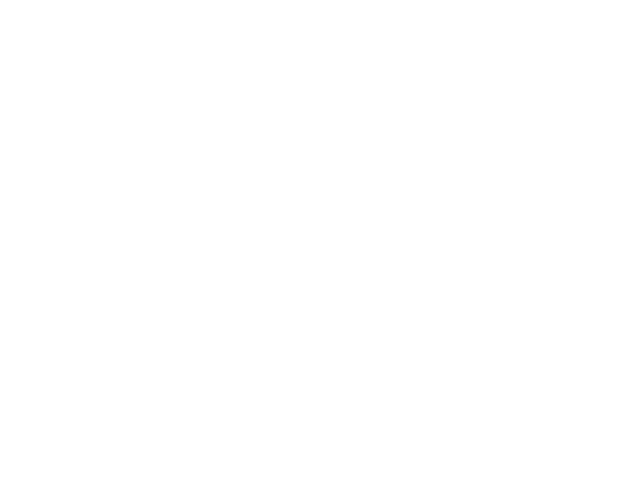

In [17]:
import matplotlib

with matplotlib.pyplot.style.context(("dark_background")):
    fig, ax = plt.subplots() 

    ax.plot(time_vals, intensities['171'], label='$171$ $\AA$') 
    ax.plot(time_vals, intensities['193'], label='$193$ $\AA$')
    ax.plot(time_vals, 5*np.asarray(intensities['211']), label='$211 \cdot 5$ $\AA$')
    ax.plot(time_vals, 50*np.asarray(intensities['304']), label='$304 \cdot 50$ $\AA$')
    ax.plot(time_vals, 125*np.asarray(intensities['335']), label='$335 \cdot 125$ $\AA$')    

    ax.set_ylabel("Intensity [DN $s^{-1} pix^{-1}$]")
    ax.set_xlabel("Time [$\Delta t = 12$ s]")
    ax.set_title('CME and Shock Observation Data')
    ax.legend(frameon=False) 
    plt.show()

In [18]:
obs = np.transpose(np.asarray([time_vals, intensities['171'], intensities['193'],
                intensities['211'], intensities['304'], intensities['335']]))

print(obs)

np.savetxt('/data/khnum/REU2018/jwaczak/data/observationData/shockData.txt', obs, header='times, 171, 193, 211, 304, 335',delimiter=',')

[[  0.          41.00626546  44.62995214   9.83831708   0.98115986
    0.34025205]
 [ 12.          40.38457959  45.34595395   9.82858626   1.04232122
    0.35569048]
 [ 24.          39.67697477  47.63400463  10.33945991   1.03243505
    0.32648737]
 [ 36.          39.0343588   50.59621871  11.51107236   1.09584244
    0.43666291]
 [ 48.          38.01895115  50.57746391  12.15469551   1.12725167
    0.4064491 ]
 [ 60.          37.63886969  50.10792783  12.29687019   1.1278466
    0.41248462]
 [ 72.          36.93839349  49.6596876   12.90144474   1.13884876
    0.41965277]
 [ 84.          36.63890564  47.75612181  13.49679693   1.2028064
    0.46432725]
 [ 96.          36.33282382  46.37516751  14.07784854   1.17252505
    0.5089575 ]
 [108.          35.5749094   44.89474691  13.83462767   1.24022381
    0.5288309 ]
 [120.          35.21532473  43.56435507  13.4421744    1.17420735
    0.58119231]
 [132.          34.62070007  42.93116506  13.29321732   1.13105979
    0.58730228]
 [144.